In [1]:
%load_ext autoreload
%autoreload 

import time
import os
import numpy as np

import torch
import torch.nn as nn

import pickle
import pandas as pd
from sklearn.model_selection import train_test_split

from torch_geometric.data import Data
from torch_geometric.utils import subgraph, to_undirected

from torch_geometric.loader import DataLoader
from torch_geometric.utils import subgraph


In [2]:
Download=False
if Download:
  !gdown 1CIFpAquzYBA98gQCdMb92fC0w6yrYf2m
  !gdown 1Cfh0VIXWTc8EK96WRZdyaqgA2-JwvsUG
  !gdown 1Cfh8hA9Tl8uCPrLSmcIQI3qCbEjOFl7C

In [3]:
Process = False
if Process: 
    # Load data from the folder
    df_features = pd.read_csv('elliptic_txs_features.csv',header=None)
    df_edges = pd.read_csv("elliptic_txs_edgelist.csv")
    df_classes =  pd.read_csv("elliptic_txs_classes.csv")
    # Add class names for easy understanding
    # reformat classes 0:licit, 1:illicit, 2:unknow 
    df_classes['class'] = df_classes['class'].map({'unknown': 2, '1':1, '2':0}) 
    # See repartition of nodes per class
    group_class = df_classes.groupby('class').count()
    # merge dataset
    df_merge = df_features.merge(df_classes, how='left', right_on="txId", left_on=0)
    # Merge features with classes
    df_merge = df_merge.sort_values(1).reset_index(drop=True)
    # Setup trans ID to node ID mapping
    nodes = df_merge[0].values

    map_id = {j:i for i,j in enumerate(nodes)} # mapping nodes to indexes

    # Create edge df that has transID mapped to nodeIDs
    edges = df_edges.copy()
    edges.txId1 = edges.txId1.map(map_id) #get nodes idx1 from edges list and filtered data
    edges.txId2 = edges.txId2.map(map_id)

    edges = edges.astype(int)

    edge_index = np.array(edges.values).T #convert into an array
    edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous() # create a tensor

    #create weights tensor with same shape of edge_index
    weights = torch.tensor([1]* edge_index.shape[1] , dtype=torch.double) 

    # Define labels
    labels = df_merge['class'].values

    # mapping txIds to corresponding indices, to pass node features to the model

    node_features = df_merge.drop(['txId'], axis=1).copy()

    # Retain known vs unknown IDs
    classified_idx = node_features['class'].loc[node_features['class']!=2].index # filter on known labels
    unclassified_idx = node_features['class'].loc[node_features['class']==2].index

    classified_illicit_idx = node_features['class'].loc[node_features['class']==1].index # filter on illicit labels
    classified_licit_idx = node_features['class'].loc[node_features['class']==0].index # filter on licit labels

    # Drop unwanted columns, 0 = transID, 1=time period, class = labels
    node_features = node_features.drop(columns=[0, 1, 'class'])

    # Convert to tensor
    node_features_t = torch.tensor(np.array(node_features.values, dtype=np.double), dtype=torch.double)# drop unused columns

    # Create a known vs unknown mask
    train_idx, valid_idx = train_test_split(classified_idx.values, test_size=0.15)

    # Create pyg dataset
    data_train = Data(x=node_features_t, edge_index=edge_index, y=torch.tensor(labels, dtype=torch.double))
    # Add in the train and valid idx
    data_train.train_idx = train_idx
    data_train.valid_idx = valid_idx
    data_train.test_idx = unclassified_idx.values
    data_train.step = torch.tensor(df_merge[1].values)
    torch.save(data_train, 'data/EllipticBTC.pt')

In [4]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

dataset = torch.load('./data/EllipticBTC.pt')
dataset.edge_index = to_undirected(dataset.edge_index)
dataset.y = dataset.y.to(torch.int64)
dataset.x = dataset.x.to(torch.float32)
dataset.train_mask = (dataset.step<=30)

In [5]:
from torch_geometric.loader import NeighborLoader

dataset_train, dataset_val, dataset_test = [], [], []
train_day = 30
train_num = 0

for i in dataset.step.unique():
    idx = torch.where(dataset.step==i)[0]
    x = dataset.x[idx]
    y = dataset.y[idx]
    edge_index, _= subgraph(idx, dataset.edge_index, relabel_nodes=True)
    daily_graph = Data(x=x, edge_index=edge_index, y=y)
    daily_graph.labeled_mask = (y<2) 
    if i<=train_day:
        dataset_train.append(daily_graph)
        train_num += daily_graph.num_nodes

    elif i>train_day and i<=train_day+4:
        dataset_val.append(daily_graph)
    elif i>train_day+4:
        dataset_test.append(daily_graph)

kwargs = {'batch_size': 1024}
train_loader = NeighborLoader(dataset, input_nodes=dataset.train_mask, num_neighbors=[25, 10], shuffle=True, **kwargs)
val_loader = DataLoader(dataset_val, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=False)

In [6]:
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score

def store_metrics(pred_scores, target_labels):

  # calculate metrics
  pred_labels = pred_scores.argmax(axis=1)
  accuracy = accuracy_score(target_labels, pred_labels)
  f1macro = f1_score(target_labels, pred_labels,average='macro')
  aucroc = roc_auc_score(target_labels, pred_scores[:,-1])
  
  return accuracy, f1macro, aucroc

In [7]:
from torch_geometric.nn import GINConv, Linear

class GINNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super().__init__()
        nn1 = nn.Sequential(Linear(input_dim, 4*hidden_dim),
                            nn.ReLU(),Linear(4*hidden_dim, 4*hidden_dim))
        self.conv1 = GINConv(nn1, train_eps=True)
        self.batchnorm1 = nn.BatchNorm1d(4*hidden_dim)
        
        nn2 = nn.Sequential(Linear(4*hidden_dim,  4*hidden_dim),
                            nn.ReLU(),Linear(4*hidden_dim, 4*hidden_dim))
        self.conv2 = GINConv(nn2, train_eps=True)
        self.batchnorm2 = nn.BatchNorm1d(4*hidden_dim)
        
        nn3 = nn.Sequential(Linear(4*hidden_dim,  hidden_dim),
                            nn.ReLU(),Linear(hidden_dim, hidden_dim))
        self.conv3 = GINConv(nn3, train_eps=True)
        self.batchnorm3 = nn.BatchNorm1d(hidden_dim)

        self.fc1 = Linear(hidden_dim, hidden_dim)
        self.batchnorm4 = nn.BatchNorm1d(hidden_dim)

        self.fc2 = Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        x = self.batchnorm1(self.conv1(x, edge_index)).relu()
        x = self.batchnorm2(self.conv2(x, edge_index)).relu()
        x = self.batchnorm3(self.conv3(x, edge_index)).relu()
        x = self.batchnorm4(self.fc1(x)).relu()
        x = self.fc2(x)
        return x

In [8]:
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torch_geometric.loader import NeighborLoader

num_features = 165
num_classes = 2
REPEAT = 5

def train(train_loader, model, optimizer):    
    model.train()
    total_loss = 0
    ys, preds = [], []
    for batch in train_loader:
        batch = batch.to(device)
        labels = batch.y[:batch.batch_size]
        labels = labels[(labels<2)]
        weight = (labels==0).sum().item() / labels.sum().item()
        optimizer.zero_grad()

        out = model(batch.x, batch.edge_index)[:batch.batch_size]       
        loss = F.cross_entropy(out[(batch.y[:batch.batch_size]<2)], labels, weight=torch.tensor([1., weight], device=device))
        loss.backward()
        optimizer.step()

        ys.append(labels)
        preds.append(torch.softmax(out[(batch.y[:batch.batch_size]<2)], dim=1))
        total_loss += loss.item() * batch.batch_size

    target_labels = torch.cat(ys, dim=0).detach().cpu().numpy()
    pred_scores = torch.cat(preds, dim=0).detach().cpu().numpy()
    train_acc, train_f1macro, train_aucroc = store_metrics(pred_scores, target_labels)

    return total_loss / len(train_loader.dataset), train_acc, train_f1macro, train_aucroc


@torch.no_grad()
def test(loader, model):
    model.eval()
    ys, preds = [], []
    daily_acc, daily_f1macro, daily_aucroc = [], [], []
    for day, data in enumerate(loader):
        out = model(data.x.to(device), data.edge_index.to(device))
        target_labels = data.y[data.labeled_mask].detach().cpu().numpy()
        pred_scores = torch.softmax(out[data.labeled_mask].squeeze(), dim=1).detach().cpu().numpy()

        ys.append(target_labels)
        preds.append(pred_scores)
        test_acc, test_f1macro, test_aucroc= store_metrics(pred_scores, target_labels)

        print("pred day {:} test acc: {:.4f} - test f1macro: {:.4f} - test roc: {:.4f}".format(
            day, test_acc, test_f1macro, test_aucroc))
        daily_acc.append(test_acc)
        daily_f1macro.append(test_f1macro)
        daily_aucroc.append(test_aucroc)


    target_labels = np.concatenate(ys, axis=0) 
    pred_scores = np.concatenate(preds, axis=0) 
    test_acc, test_f1macro, test_aucroc= store_metrics(pred_scores, target_labels)
    print("final test acc: {:.4f} - test f1macro: {:.4f} - test roc: {:.4f}".format(test_acc, test_f1macro, test_aucroc))

    return test_acc, test_f1macro, test_aucroc, daily_acc, daily_f1macro, daily_aucroc

results_full = {
    'acc': {},
    'f1macro': {},
    'f1micro': {},
    'aucroc': {}
}

results_full = {
    'acc' : np.zeros((16, REPEAT)),
    'f1macro' : np.zeros((16, REPEAT)),
    'aucroc' : np.zeros((16, REPEAT))
}

for repeat in range(REPEAT):
    model = GINNet(num_features, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

    for epoch in range(1, 201):
        loss, train_acc, train_f1macro, train_aucroc = train(train_loader, model, optimizer)

    test_acc, test_f1macro, test_aucroc, daily_acc, daily_f1macro, daily_aucroc= test(test_loader, model)

    results_full['acc'][:15,repeat] = np.array(daily_acc)
    results_full['f1macro'][:15,repeat] = np.array(daily_f1macro)
    results_full['aucroc'][:15,repeat] = np.array(daily_aucroc)
    results_full['acc'][15,repeat] = test_acc
    results_full['f1macro'][15,repeat] = test_f1macro
    results_full['aucroc'][15,repeat] = test_aucroc

print("acc: {:.4f} - f1macro: {:.4f} with var {:.4f} -aucroc: {:.4f} with var {:.4f}".format(
                                            np.asarray(results_full['acc'][15,:]).mean(), 
                                            np.asarray(results_full['f1macro'][15,:]).mean(), 
                                            np.asarray(results_full['f1macro'][15,:]).var(), 
                                            np.asarray(results_full['aucroc'][15,:]).mean(), 
                                            np.asarray(results_full['aucroc'][15,:]).var()
                                                ))

pred day 0 test acc: 0.9664 - test f1macro: 0.9220 - test roc: 0.9661
pred day 1 test acc: 0.9795 - test f1macro: 0.7550 - test roc: 0.8699
pred day 2 test acc: 0.9478 - test f1macro: 0.7540 - test roc: 0.8163
pred day 3 test acc: 0.8915 - test f1macro: 0.7165 - test roc: 0.8438
pred day 4 test acc: 0.9467 - test f1macro: 0.6861 - test roc: 0.8842
pred day 5 test acc: 0.9323 - test f1macro: 0.6973 - test roc: 0.8395
pred day 6 test acc: 0.9276 - test f1macro: 0.7335 - test roc: 0.9118
pred day 7 test acc: 0.9271 - test f1macro: 0.7487 - test roc: 0.8923
pred day 8 test acc: 0.9547 - test f1macro: 0.4884 - test roc: 0.5950
pred day 9 test acc: 0.9818 - test f1macro: 0.4954 - test roc: 0.5395
pred day 10 test acc: 0.9918 - test f1macro: 0.4979 - test roc: 0.7010
pred day 11 test acc: 0.9958 - test f1macro: 0.4989 - test roc: 0.4972
pred day 12 test acc: 0.9740 - test f1macro: 0.4934 - test roc: 0.5996
pred day 13 test acc: 0.9236 - test f1macro: 0.4801 - test roc: 0.7253
pred day 14 test

In [9]:
from GUIDE.guide import GUIDE
args = {}
args['dataname'] = 'BTC'
args['shards_number'] = 20
args['device'] = device
partations_fast = []
for gi in range(len(dataset_train)):
    args['gi'] = gi    
    GUIDE_Fast = GUIDE(edge_indexs=dataset_train[gi].edge_index, labels=dataset_train[gi].y, k=args['shards_number'])
    p1 = GUIDE_Fast.fit(method='Fast', alpha_=1e-3)
    p1_saved = GUIDE_Fast.subgraph_repair(x = dataset_train[gi].x, REPAIR_METHOD='MixUp', PATH='checkpoints/',DATA_NAME='{}'.format(args['dataname']), MULTI_GRAPH = args['gi'])
    savename = p1_saved.DPATH.split('partid')[0]+p1_saved.method+'_saved.pt'
    torch.save(p1_saved, savename)
    partations_fast.append(p1_saved)


method:Fast, running time:2.6492013931274414, balance:-0.022588832487309644, fairness:-0.02784466404446429
method:Fast, running time:0.7876403331756592, balance:-0.030281691484048332, fairness:-0.03441527466679974
method:Fast, running time:1.626281499862671, balance:-0.0221265669838393, fairness:-0.026063615053586627
method:Fast, running time:1.3226237297058105, balance:-0.029834886018534276, fairness:-0.025382574670866086
method:Fast, running time:1.6924829483032227, balance:-0.02491547846538292, fairness:-0.027027371620224984
method:Fast, running time:0.7259957790374756, balance:-0.030499075785582256, fairness:-0.02294045189340277
method:Fast, running time:1.4213600158691406, balance:-0.03356481481481482, fairness:-0.02428206754243715
method:Fast, running time:0.7750153541564941, balance:-0.027294142673655906, fairness:-0.039143345045793344
method:Fast, running time:0.9760699272155762, balance:-0.028983187160079627, fairness:-0.027722462180385897
method:Fast, running time:1.755866765

In [10]:
from GUIDE.kernel_vector import PyramidMatchVector

gis_keys_graph = {}
pm_kernel = PyramidMatchVector()

for gi in range(len(dataset_train)):
    gis_keys_graph[gi] = {}
    for part_id in range(args['shards_number']):
        loadname = partations_fast[gi].DPATH.replace('partid', 'part'+str(part_id))
        sub_graph = torch.load(loadname)
        gis_keys_graph[gi][part_id] = sub_graph
        # kernel feature extraction for further use
        subg_kfea = pm_kernel.parse_input([sub_graph.edge_index.cpu()])
        savekfean = loadname.replace('subgraphs', 'subgkfeas').replace('.pt', '_PM'+'.pt')
        os.makedirs(os.path.dirname(savekfean), exist_ok=True)
        torch.save(subg_kfea, savekfean)
        partations_fast[gi].FPATH = savekfean.replace('part'+str(part_id), 'partid')
        # model save path
        savemodeln = loadname.replace('subgraphs', 'submodels').replace('.pt', '_'+ 'GINNet' +'.pt').replace('part'+str(part_id), 'partid')
        savemodeln = savemodeln.split('graph')[0] + 'model_part' + savemodeln.split('_part')[1]
        partations_fast[gi].MPATH = savemodeln.replace('part'+str(part_id), 'partid')

In [11]:
import os
import torch.nn.functional as F

args['num_features'] = num_features
args['num_classes'] = num_classes
results_Fast = {
    'acc' : np.zeros((16, REPEAT)),
    'f1macro' : np.zeros((16, REPEAT)),
    'aucroc' : np.zeros((16, REPEAT))
}

for repeat in range(REPEAT):
    for part_id in p1_saved.shards_ids.keys():
        # submodel training
        start = time.time()
        submodel = GINNet(input_dim=args['num_features'],
                    output_dim=args['num_classes']).to(args['device'])

        optimizer = torch.optim.Adam(
            submodel.parameters(), lr=0.01, weight_decay=1e-5)
        for epoch in range(1, 201):
            submodel.train()
            for gi in range(len(dataset_train)):
                sub_graph = gis_keys_graph[gi][part_id]
                sub_graph = sub_graph.to(device)
                labels = sub_graph.y[sub_graph.y < 2]
                if labels.sum() > 0:
                    weight = (labels == 0).sum().item() / labels.sum().item()
                else:
                    weight = 1.0
                optimizer.zero_grad()
                out = submodel(sub_graph.x, sub_graph.edge_index)[
                    sub_graph.train_mask]
                loss = F.cross_entropy(out[torch.where(sub_graph.y < 2)[
                    0]], labels, weight=torch.tensor([1., weight], device=device))

                loss.backward()
                optimizer.step()

        submodel.to('cpu')
        sub_graph = sub_graph.to('cpu')
        savemodeln = partations_fast[gi].MPATH.replace('partid', 'part'+str(part_id))
        os.makedirs(os.path.dirname(savemodeln), exist_ok=True)
        torch.save(submodel.state_dict(), savemodeln)
        del submodel, sub_graph, optimizer, out, loss

    preds, targets = [], []
    for day, data in enumerate(test_loader):
        pm_kernel = PyramidMatchVector()
        subgt_kfea = pm_kernel.parse_input([data.edge_index.cpu()])
        subg_kfea = []
        subouts = []
        for part_id in p1_saved.shards_ids.keys():
            for gi in range(len(dataset_train)):
                loadname = partations_fast[gi].FPATH.replace('partid', 'part'+str(part_id))
                subg_kfea += torch.load(loadname)

            submodel = GINNet(input_dim=args['num_features'],
                        output_dim=args['num_classes']).to(args['device'])
            savemodeln = partations_fast[gi].MPATH.replace('partid', 'part'+str(part_id))
            submodel.load_state_dict(torch.load(savemodeln))
            submodel.eval()
            subout = torch.softmax(submodel(data.x.to(args['device']), data.edge_index.to(args['device'])), dim=1)
            if 'labeled_mask' in data:
                subout = subout[data.labeled_mask]

            subouts.append(subout.detach().to('cpu'))
            submodel.to('cpu')
            del submodel, subout

        suboutTensor = torch.stack(subouts)

        daily_weights = pm_kernel.kernel_similarity(subgt_kfea, subg_kfea)
        daily_weights = torch.tensor(daily_weights).to(torch.float32).reshape(len(p1_saved.shards_ids.keys()), -1).mean(dim=-1)
        saveweightn = partations_fast[gi].MPATH.replace('partid/submodels/','').replace('model_partid', f'day{day}_weight')
        os.makedirs(os.path.dirname(saveweightn), exist_ok=True)
        torch.save(daily_weights, saveweightn)

        weights = F.softmax(daily_weights, dim=0)
        weighted_pred = torch.tensordot(suboutTensor, weights, dims=([0], [0]))

        if 'labeled_mask' in data:
            target_labels = data.y[data.labeled_mask].detach().cpu().numpy()
        else:
            target_labels = data.y.detach().cpu().numpy()
        
        test_acc, test_f1macro, test_aucroc= store_metrics(weighted_pred.detach().cpu().numpy(), target_labels)
        print("pred day {} test acc: {:.4f} - test f1macro: {:.4f} - test roc: {:.4f} ".format(day,
            test_acc, test_f1macro, test_aucroc))
        results_Fast['acc'][day, repeat] = test_acc
        results_Fast['f1macro'][day, repeat] = test_f1macro
        results_Fast['aucroc'][day, repeat] = test_aucroc
        preds.append(weighted_pred.detach().cpu().numpy())
        targets.append(target_labels)

    pred_all = np.concatenate(preds, axis=0)
    targets_all = np.concatenate(targets, axis=0)
    test_acc, test_f1macro, test_aucroc= store_metrics(pred_all, targets_all)
    print("final test acc: {:.4f} - test f1macro: {:.4f} - test roc: {:.4f}".format(test_acc, test_f1macro, test_aucroc))
    results_Fast['acc'][-1, repeat] = test_acc
    results_Fast['f1macro'][-1, repeat] = test_f1macro
    results_Fast['aucroc'][-1, repeat] = test_aucroc

pred day 0 test acc: 0.9493 - test f1macro: 0.8866 - test roc: 0.9588 
pred day 1 test acc: 0.9690 - test f1macro: 0.6649 - test roc: 0.8888 
pred day 2 test acc: 0.9438 - test f1macro: 0.7904 - test roc: 0.8826 
pred day 3 test acc: 0.9034 - test f1macro: 0.8148 - test roc: 0.9019 
pred day 4 test acc: 0.9163 - test f1macro: 0.6846 - test roc: 0.9147 
pred day 5 test acc: 0.9207 - test f1macro: 0.7119 - test roc: 0.8345 
pred day 6 test acc: 0.9072 - test f1macro: 0.7367 - test roc: 0.8185 
pred day 7 test acc: 0.9401 - test f1macro: 0.8445 - test roc: 0.9447 
pred day 8 test acc: 0.9642 - test f1macro: 0.4909 - test roc: 0.6000 
pred day 9 test acc: 0.8605 - test f1macro: 0.4625 - test roc: 0.5510 
pred day 10 test acc: 0.9525 - test f1macro: 0.4878 - test roc: 0.6219 
pred day 11 test acc: 0.9621 - test f1macro: 0.4903 - test roc: 0.8577 
pred day 12 test acc: 0.9622 - test f1macro: 0.4904 - test roc: 0.6551 
pred day 13 test acc: 0.9214 - test f1macro: 0.4796 - test roc: 0.7888 
pr

In [12]:
from GUIDE.guide import GUIDE
args = {}
args['dataname'] = 'BTC'
args['shards_number'] = 20
args['device'] = device
partations_sr = []
for gi in range(len(dataset_train)):
    args['gi'] = gi    
    GUIDE_SR = GUIDE(edge_indexs=dataset_train[gi].edge_index, labels=dataset_train[gi].y, k=args['shards_number'])
    p1 = GUIDE_SR.fit(method='SR', alpha_=1e-3, beta_=1e-2)
    p1_saved = GUIDE_SR.subgraph_repair(x = dataset_train[gi].x, REPAIR_METHOD='MixUp', PATH='checkpoints/',DATA_NAME='{}'.format(args['dataname']), MULTI_GRAPH = args['gi'])
    savename = p1_saved.DPATH.split('partid')[0]+p1_saved.method+'_saved.pt'
    torch.save(p1_saved, savename)
    partations_sr.append(p1_saved)

from GUIDE.kernel_vector import PyramidMatchVector

gis_keys_graph = {}
pm_kernel = PyramidMatchVector()

for gi in range(len(dataset_train)):
    gis_keys_graph[gi] = {}
    for part_id in range(args['shards_number']):
        loadname = partations_sr[gi].DPATH.replace('partid', 'part'+str(part_id))
        sub_graph = torch.load(loadname)
        gis_keys_graph[gi][part_id] = sub_graph
        # kernel feature extraction for further use
        subg_kfea = pm_kernel.parse_input([sub_graph.edge_index.cpu()])
        savekfean = loadname.replace('subgraphs', 'subgkfeas').replace('.pt', '_PM'+'.pt')
        os.makedirs(os.path.dirname(savekfean), exist_ok=True)
        torch.save(subg_kfea, savekfean)
        partations_sr[gi].FPATH = savekfean.replace('part'+str(part_id), 'partid')
        # model save path
        savemodeln = loadname.replace('subgraphs', 'submodels').replace('.pt', '_'+ 'GINNet' +'.pt').replace('part'+str(part_id), 'partid')
        savemodeln = savemodeln.split('graph')[0] + 'model_part' + savemodeln.split('_part')[1]
        partations_sr[gi].MPATH = savemodeln.replace('part'+str(part_id), 'partid')


0.04010152284263959 0.03331892601423409 -0.05
method:SR, running time:6.143684387207031, balance:-0.04010152284263959, fairness:-0.03331892601423409
0.053036971830985914 0.03348032911508182 -0.05
method:SR, running time:2.7043659687042236, balance:-0.053036971830985914, fairness:-0.03348032911508182
0.05354176106328349 0.03564643422207327 -0.05
method:SR, running time:4.2195470333099365, balance:-0.05354176106328349, fairness:-0.03564643422207327
0.05289829508106172 0.031452222527289624 -0.05
method:SR, running time:3.734086513519287, balance:-0.05289829508106172, fairness:-0.031452222527289624
0.061245038056222896 0.02726945598790409 -0.05
method:SR, running time:4.745819807052612, balance:-0.061245038056222896, fairness:-0.02726945598790409
0.044454712083291215 0.02646041691012944 -0.05
method:SR, running time:2.6471478939056396, balance:-0.044454712083291215, fairness:-0.02646041691012944
0.05406746031746032 0.03189369192743313 -0.05
method:SR, running time:3.806093692779541, balanc

In [13]:

import os
import torch.nn.functional as F

args['num_features'] = num_features
args['num_classes'] = num_classes
results_SR = {
    'acc' : np.zeros((16, REPEAT)),
    'f1macro' : np.zeros((16, REPEAT)),
    'aucroc' : np.zeros((16, REPEAT))
}

for repeat in range(REPEAT):
    for part_id in p1_saved.shards_ids.keys():
        # submodel training
        start = time.time()
        submodel = GINNet(input_dim=args['num_features'],
                    output_dim=args['num_classes']).to(args['device'])

        optimizer = torch.optim.Adam(
            submodel.parameters(), lr=0.01, weight_decay=1e-5)
        for epoch in range(1, 201):
            submodel.train()
            for gi in range(len(dataset_train)):
                sub_graph = gis_keys_graph[gi][part_id]
                sub_graph = sub_graph.to(device)
                labels = sub_graph.y[sub_graph.y < 2]
                if labels.sum() > 0:
                    weight = (labels == 0).sum().item() / labels.sum().item()
                else:
                    weight = 1.0
                optimizer.zero_grad()
                out = submodel(sub_graph.x, sub_graph.edge_index)[
                    sub_graph.train_mask]
                loss = F.cross_entropy(out[torch.where(sub_graph.y < 2)[
                    0]], labels, weight=torch.tensor([1., weight], device=device))

                loss.backward()
                optimizer.step()

        submodel.to('cpu')
        sub_graph = sub_graph.to('cpu')
        savemodeln = partations_sr[gi].MPATH.replace('partid', 'part'+str(part_id))
        os.makedirs(os.path.dirname(savemodeln), exist_ok=True)
        torch.save(submodel.state_dict(), savemodeln)
        del submodel, sub_graph, optimizer, out, loss

    preds, targets = [], []
    for day, data in enumerate(test_loader):
        pm_kernel = PyramidMatchVector()
        subgt_kfea = pm_kernel.parse_input([data.edge_index.cpu()])
        subg_kfea = []
        subouts = []
        for part_id in p1_saved.shards_ids.keys():
            for gi in range(len(dataset_train)):
                loadname = partations_sr[gi].FPATH.replace('partid', 'part'+str(part_id))
                subg_kfea += torch.load(loadname)

            submodel = GINNet(input_dim=args['num_features'],
                        output_dim=args['num_classes']).to(args['device'])
            savemodeln = partations_sr[gi].MPATH.replace('partid', 'part'+str(part_id))
            submodel.load_state_dict(torch.load(savemodeln))
            submodel.eval()
            subout = torch.softmax(submodel(data.x.to(args['device']), data.edge_index.to(args['device'])), dim=1)
            if 'labeled_mask' in data:
                subout = subout[data.labeled_mask]

            subouts.append(subout.detach().to('cpu'))
            submodel.to('cpu')
            del submodel, subout

        suboutTensor = torch.stack(subouts)

        daily_weights = pm_kernel.kernel_similarity(subgt_kfea, subg_kfea)
        daily_weights = torch.tensor(daily_weights).to(torch.float32).reshape(len(p1_saved.shards_ids.keys()), -1).mean(dim=-1)
        saveweightn = partations_sr[gi].MPATH.replace('partid/submodels/','').replace('model_partid', f'day{day}_weight')
        os.makedirs(os.path.dirname(saveweightn), exist_ok=True)
        torch.save(daily_weights, saveweightn)

        weights = F.softmax(daily_weights, dim=0)
        weighted_pred = torch.tensordot(suboutTensor, weights, dims=([0], [0]))

        if 'labeled_mask' in data:
            target_labels = data.y[data.labeled_mask].detach().cpu().numpy()
        else:
            target_labels = data.y.detach().cpu().numpy()
        
        test_acc, test_f1macro, test_aucroc= store_metrics(weighted_pred.detach().cpu().numpy(), target_labels)
        print("pred day {} test acc: {:.4f} - test f1macro: {:.4f} - test roc: {:.4f} ".format(day,
            test_acc, test_f1macro, test_aucroc))
        results_SR['acc'][day, repeat] = test_acc
        results_SR['f1macro'][day, repeat] = test_f1macro
        results_SR['aucroc'][day, repeat] = test_aucroc
        preds.append(weighted_pred.detach().cpu().numpy())
        targets.append(target_labels)

    pred_all = np.concatenate(preds, axis=0)
    targets_all = np.concatenate(targets, axis=0)
    test_acc, test_f1macro, test_aucroc= store_metrics(pred_all, targets_all)
    print("final test acc: {:.4f} - test f1macro: {:.4f} - test roc: {:.4f}".format(test_acc, test_f1macro, test_aucroc))
    results_SR['acc'][-1, repeat] = test_acc
    results_SR['f1macro'][-1, repeat] = test_f1macro
    results_SR['aucroc'][-1, repeat] = test_aucroc

pred day 0 test acc: 0.9545 - test f1macro: 0.8943 - test roc: 0.9477 
pred day 1 test acc: 0.9754 - test f1macro: 0.6755 - test roc: 0.8349 
pred day 2 test acc: 0.9378 - test f1macro: 0.7449 - test roc: 0.8676 
pred day 3 test acc: 0.8942 - test f1macro: 0.7695 - test roc: 0.9108 
pred day 4 test acc: 0.9239 - test f1macro: 0.6489 - test roc: 0.8701 
pred day 5 test acc: 0.9273 - test f1macro: 0.7089 - test roc: 0.8213 
pred day 6 test acc: 0.9311 - test f1macro: 0.7622 - test roc: 0.8089 
pred day 7 test acc: 0.9540 - test f1macro: 0.8669 - test roc: 0.9456 
pred day 8 test acc: 0.9657 - test f1macro: 0.4913 - test roc: 0.5456 
pred day 9 test acc: 0.9208 - test f1macro: 0.4794 - test roc: 0.5058 
pred day 10 test acc: 0.9730 - test f1macro: 0.4932 - test roc: 0.5883 
pred day 11 test acc: 0.9831 - test f1macro: 0.4958 - test roc: 0.8430 
pred day 12 test acc: 0.9704 - test f1macro: 0.4925 - test roc: 0.7226 
pred day 13 test acc: 0.9236 - test f1macro: 0.4801 - test roc: 0.8709 
pr

/tmp/ipykernel_87122/15375388.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


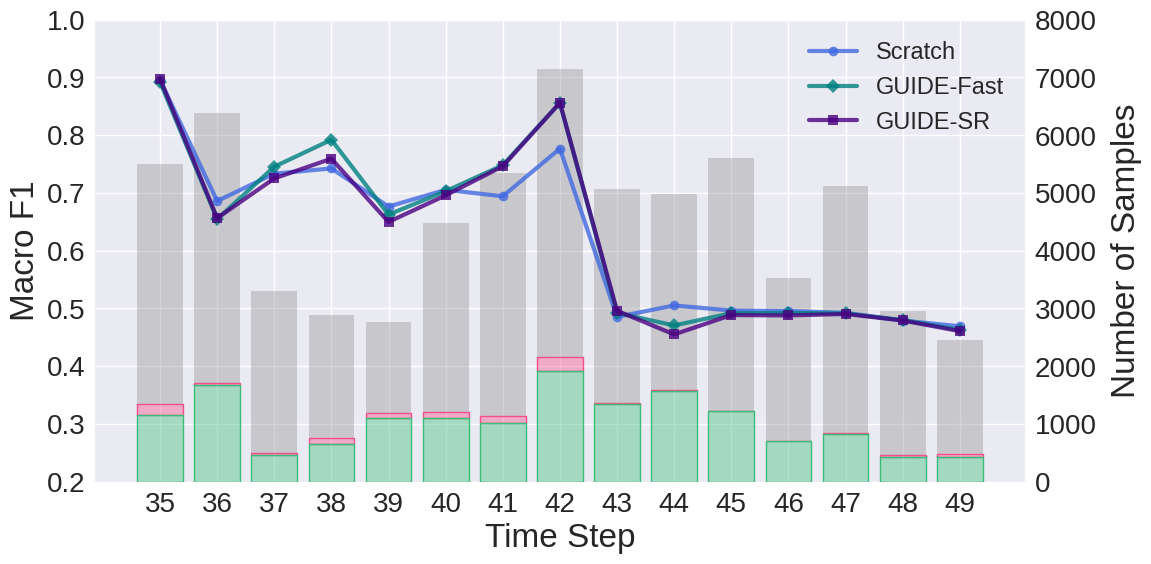

In [14]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plot_daily = {}
plot_daily['licit'] = []
plot_daily['illicit'] = []
plot_daily['unknown'] = []
for t in range(len(dataset_test)):
    plot_daily['licit'].append((dataset_test[t].y==0).sum().item())
    plot_daily['illicit'].append((dataset_test[t].y==1).sum().item())
    plot_daily['unknown'].append((dataset_test[t].y==2).sum().item())
#     print(plot_daily['illicit'][-1], (dataset_test[t].y==1).sum().item()/(dataset_test[t].y==0).sum().item())
    
plt.style.use('seaborn')
fig, axright =plt.subplots(figsize=(12, 6))
x = range(35,50)
axleft = axright.twinx()
axright.bar(x,list(np.asarray(plot_daily['unknown'] )), bottom= np.asarray(plot_daily['illicit'] )+np.asarray(plot_daily['licit'] ), 
        label='# Unknown',color=(150/256, 150/256, 150/256, 0.4))
axright.bar(x,list(np.asarray(plot_daily['illicit'] )), label='# Illicit',bottom= np.asarray(plot_daily['licit'] ), 
         color=(246/256, 78/256, 139/256, 0.4), linewidth=1, edgecolor = (246/256, 78/256, 139/256, 1.0))

axright.bar(x,list(np.asarray(plot_daily['licit'] )), 
        label='# licit',color=(58/256, 190/256, 120/256, 0.4), linewidth=1, edgecolor=(58/256, 190/256, 120/256, 1))

axright.set_ylim([0,8000])
# axright.legend(loc=(0.79, 0.75), prop={'size':17})
axright.yaxis.tick_right()
axright.set_ylabel('Number of Samples', fontsize=24, labelpad=10)
axright.yaxis.set_label_position("right")
axright.yaxis.set_tick_params(labelsize=20)
axright.set_xlabel('Time Step', fontsize=24)
axright.set_xticks(range(35,50))
axright.xaxis.set_tick_params(labelsize=20)

axleft.plot(x,list(results_full['f1macro'][:-1].mean(axis=1)), linewidth=3.0, alpha=0.8, color="royalblue", linestyle="-", marker = 'o', label= 'Scratch')
axleft.plot(x,list(results_Fast['f1macro'][:-1].mean(axis=1)), linewidth=3.0, alpha=0.8,  color="teal", linestyle="-", marker = 'D',label= 'GUIDE-Fast')
axleft.plot(x,list(results_SR['f1macro'][:-1].mean(axis=1)), linewidth=3.0, alpha=0.8,  color="indigo", linestyle="-", marker = 's',label= 'GUIDE-SR')

axleft.legend(prop={'size':17})
# axleft.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=4, prop={'size':17})
axleft.set_ylim([0.2, 1])
axleft.yaxis.tick_left()
axleft.set_ylabel('Macro F1', fontsize=24)
axleft.yaxis.set_label_position("left")
axleft.yaxis.set_tick_params(labelsize=20)
axleft.grid()
axleft.set_xlabel('Time Step', fontsize=24)

# plt.xlabel('Macro F1 results over test time span', fontsize=20)
# plt.grid()
dataname = 'EllipticBTC'
# plt.savefig(f'logs/BTC_GIN_20_MacroF1_{dataname}.pdf', format="pdf", bbox_inches='tight')
plt.show()

    

/tmp/ipykernel_87122/2370332187.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


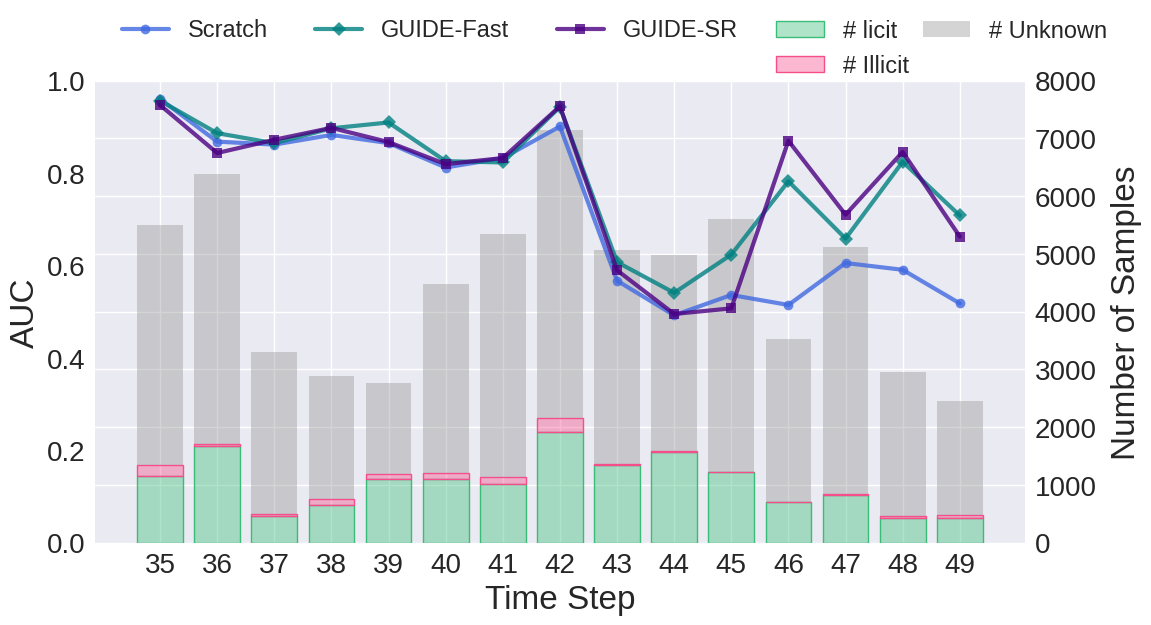

In [15]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.style.use('seaborn')
fig, axright =plt.subplots(figsize=(12, 6))
x = range(35,50)
axleft = axright.twinx()
axright.bar(x,list(np.asarray(plot_daily['licit'] )), 
        label='# licit',color=(58/256, 190/256, 120/256, 0.4), linewidth=1, edgecolor=(58/256, 190/256, 120/256, 1))
axright.bar(x,list(np.asarray(plot_daily['illicit'] )), label='# Illicit',bottom= np.asarray(plot_daily['licit'] ), 
         color=(246/256, 78/256, 139/256, 0.4), linewidth=1, edgecolor = (246/256, 78/256, 139/256, 1.0))

axright.bar(x,list(np.asarray(plot_daily['unknown'] )), bottom= np.asarray(plot_daily['illicit'] )+np.asarray(plot_daily['licit'] ), 
        label='# Unknown',color=(150/256, 150/256, 150/256, 0.4))

axright.set_ylim([0,8000])
# axright.legend(loc='best', prop={'size':17})
axright.legend(loc='upper left', bbox_to_anchor=(0.71, 1.179), ncol=2, columnspacing=0.6, prop={'size':17})

axright.yaxis.tick_right()
axright.set_ylabel('Number of Samples', fontsize=24, labelpad=10)
axright.yaxis.set_label_position("right")
axright.yaxis.set_tick_params(labelsize=20)
axright.set_xticks(range(35,50))
axright.xaxis.set_tick_params(labelsize=20)
axright.set_xlabel('Time Step', fontsize=24)

axleft.plot(x,list(results_full['aucroc'][:-1].mean(axis=1)), linewidth=3.0, alpha=0.8,  color="royalblue", linestyle="-", marker = 'o', label= 'Scratch')
axleft.plot(x,list(results_Fast['aucroc'][:-1].mean(axis=1)), linewidth=3.0, alpha=0.8,  color="teal", linestyle="-", marker = 'D',label= 'GUIDE-Fast')
axleft.plot(x,list(results_SR['aucroc'][:-1].mean(axis=1)), linewidth=3.0, alpha=0.8,  color="indigo", linestyle="-", marker = 's',label= 'GUIDE-SR')

axleft.legend(prop={'size':17})
axleft.legend(loc='upper center', bbox_to_anchor=(0.36, 1.18), ncol=3, prop={'size':17})

axleft.set_ylim([0, 1])
axleft.yaxis.tick_left()
axleft.set_ylabel('AUC', fontsize=24)
axleft.yaxis.set_label_position("left")
axleft.yaxis.set_tick_params(labelsize=20)
axleft.grid()
axleft.set_xlabel('Time Step', fontsize=24)

# plt.savefig(f'logs/BTC_GIN_20_AUC_{dataname}.pdf', format="pdf", bbox_inches='tight')
plt.show()

    

In [24]:
torch.save(partations_fast, './checkpoints/BTC/partitions_fast.pt')
torch.save(partations_sr, './checkpoints/BTC/partitions_sr.pt')
torch.save(results_full, './checkpoints/BTC/results_full.pt')
torch.save(results_Fast, './checkpoints/BTC/results_fast.pt')
torch.save(results_SR, './checkpoints/BTC/results_sr.pt')

In [8]:
partations_fast = torch.load('./checkpoints/BTC/partitions_fast.pt')

In [9]:
import shutil

src_dir = 'checkpoints/BTC'
dst_dir = 'checkpoints/BTC_copy'

if os.path.exists(dst_dir):
    shutil.rmtree(dst_dir)

shutil.copytree(src_dir, dst_dir)

'checkpoints/BTC_copy'

In [10]:
def calculate_distance(data0, data1, distance='l2_norm' ):
    if distance == 'l2_norm':
        return torch.norm(data0-data1,dim=1)
    elif distance =='direct_diff':
        return data0 - data1
    else:
        raise Exception("Unsupported distance")

def evaluate_attack_with_AUC(data, label):
    return roc_auc_score(label, data.reshape(-1, 1))


In [11]:
# gis_keys_graph
id_gi_part_innerid = []
for gi in range(train_day):
    ids = torch.where(dataset.step==gi+1)[0].tolist()
    gis = [gi] * len(ids)
    inday_ids = range(len(ids))
    part_ids = partations_fast[gi].ids_shards.values()
    id_gi_part_innerid += list(zip(ids, gis, part_ids, inday_ids))

torch.save(id_gi_part_innerid, partations_fast[gi].DPATH.split('partid')[0]+ 'id_gi_part_innerid.pt')


In [12]:
import copy
import random
import collections
from itertools import compress
from GUIDE.kernel_vector import PyramidMatchVector
num_features = 165
num_classes = 2

args = {}
args['dataname'] = 'BTC'
args['shards_number'] = 20
args['device'] = device
args['num_features'] = num_features
args['num_classes'] = num_classes

unlearning_number = 100
print(f'unlearning_number:{unlearning_number}')
G_ny0 = [dataset_test[-1].edge_index.cpu()]
pm_kernel = PyramidMatchVector(normalize=True, with_labels=False)
G_ny0 = pm_kernel.parse_input(G_ny0)
average_countpart = []
train_labeled_idx = torch.where(torch.logical_and(dataset.step<=30,dataset.y<2))[0].tolist()
unlearning_id = random.sample(train_labeled_idx,k=int(unlearning_number))
sub_tuples = [id_gi_part_innerid[i] for i in unlearning_id]

gi_tuples = collections.defaultdict(list)
for tup in sub_tuples:
    gi_tuples[tup[1]].append(tup[2:])

gi_part_uid = {}
average_countpart_ = []
for i in gi_tuples.keys():
    gi_tuples_in = collections.defaultdict(list)
    for j in gi_tuples[i]:
        gi_tuples_in[j[0]].append(j[1])

    gi_part_uid[i] = gi_tuples_in
    average_countpart_ += list(gi_tuples_in.keys())

average_countpart.append(len(set(average_countpart_)))



unlearning_number:100


In [13]:
import torch.nn.functional as F

gis_keys_graph = {}
pm_kernel = PyramidMatchVector()

for gi in range(len(dataset_train)):
    gis_keys_graph[gi] = {}
    for part_id in range(args['shards_number']):
        loadname = partations_fast[gi].DPATH.replace('partid', 'part'+str(part_id))
        sub_graph = torch.load(loadname)
        gis_keys_graph[gi][part_id] = sub_graph

gis_keys_graph_update = copy.deepcopy(gis_keys_graph)
part_set = []
for gi in gi_part_uid.keys():
    for part in gi_part_uid[gi].keys():
        part_set.append(part)
        reserve_mask = torch.tensor([False if id in gi_part_uid[gi][part] else True for id in gis_keys_graph_update[gi][part].uids])
        sub_graph = gis_keys_graph_update[gi][part].subgraph(reserve_mask)
        sub_graph.uids = list(compress(sub_graph.uids, reserve_mask.tolist()))
        sub_graph.labeled_mask =  (sub_graph.y <2)                  
        gis_keys_graph_update[gi][part] = sub_graph

G_nx0 = []
part_set = set(part_set)
# the following part can be parallel
for part in part_set:
    for gi in gis_keys_graph_update.keys():
        G_nx0.append(gis_keys_graph_update[gi][part].edge_index.to('cpu'))

    submodel = GINNet(args['num_features'],
                        args['num_classes']).to(args['device'])
    optimizer = torch.optim.Adam(
        submodel.parameters(), lr=0.01, weight_decay=1e-5)

    for epoch in range(1, 201):
        submodel.train()
        for gi in range(len(dataset_train)):
            sub_graph = gis_keys_graph_update[gi][part]
            sub_graph = sub_graph.to(args['device'])
            labels = sub_graph.y[sub_graph.y<2]
            if labels.sum() > 0:
                weight = (labels == 0).sum().item() / labels.sum().item()
            else:
                weight = 1.0
            optimizer.zero_grad()
            out = submodel(sub_graph.x, sub_graph.edge_index)[
                sub_graph.train_mask]
            loss = F.cross_entropy(out[torch.where(sub_graph.y<2)[0]], labels,  weight=torch.tensor([1., weight], device=device))

            loss.backward()
            optimizer.step()

    submodel.to('cpu')
    sub_graph.to('cpu')
    savemodeln = partations_fast[gi].MPATH.replace('/partid', '_copy/partid').replace('partid', 'part'+str(part_id))
    os.makedirs(os.path.dirname(savemodeln), exist_ok=True)
    torch.save(submodel.state_dict(), savemodeln)

G_nx0 = pm_kernel.parse_input(G_nx0)

In [21]:
method = 'Fast'
positive0, negative0 = {}, {}
positive0[method], negative0[method]  = [], []

submodellist = []
part_set_all = range(args['shards_number'])
for part in part_set_all:
    submodel = GINNet(args['num_features'],
                        args['num_classes'])

    loadname = partations_fast[gi].MPATH.replace('partid', 'part'+str(part_id))

    submodel.load_state_dict(torch.load(loadname))
    submodel.eval()
    submodellist.append(submodel)

subouts_train = []
subout_tests = []
part_set_all = range(args['shards_number'])
for part in part_set_all:
    subout_train = []
    for data in dataset_train:
        subout_train_daily= torch.softmax(submodellist[part](data.x, data.edge_index),dim=1)
        subout_train.append(subout_train_daily)

    subout_train = torch.concat(subout_train)
    subout_train_ = subout_train[unlearning_id]
    subouts_train.append(subout_train_.detach())

    subout_test = []
    for data in dataset_test:
        subout_test_daily= torch.softmax(submodellist[part](data.x, data.edge_index),dim=1)
        subout_test.append(subout_test_daily)

    subout_test = torch.concat(subout_test)
    subout_tests.append(subout_test.detach())

suboutTensor = torch.stack(subouts_train)
suboutTensorn = torch.stack(subout_tests)

# weights_gi = torch.tensor([1.0/args['shards_number']
#                         for _ in range(args['shards_number'])])
weights_gi = torch.load(partations_fast[gi].MPATH.replace('partid/submodels/','').replace('model_partid', f'day{14}_weight'))

summed = torch.tensordot(
    suboutTensor, torch.softmax(weights_gi, dim=0), dims=([0], [0]))
positive0[method].append(summed.cpu())

summed = torch.tensordot(
    suboutTensorn, torch.softmax(weights_gi, dim=0), dims=([0], [0]))
negative0[method].append(summed.cpu())
del suboutTensor, suboutTensorn, summed

In [22]:
tmp = time.strftime("%Y%m%d-%H%M%S")
savename = partations_fast[gi].MPATH.split('partid')[0]+f'evaluation_attack_partition_{method}_BTC_unlearning_idrnd'
savename += ''.join(tmp)
savename += ''.join('.pt')
torch.save(unlearning_id,savename)

savename = partations_fast[gi].MPATH.split('partid')[0]+f'evaluation_attack_partition_{method}_BTC_positive0'
savename += ''.join(tmp)
savename += ''.join('.pt')
torch.save(positive0,savename)
savename = partations_fast[gi].MPATH.split('partid')[0]+f'evaluation_attack_partition_{method}_BTC_negative0'
savename += ''.join(tmp)
savename += ''.join('.pt')
torch.save(negative0,savename)

In [23]:
method = 'Fast'
positive1, negative1 = {}, {}
positive1[method], negative1[method]  = [], []

submodellist = []
part_set_all = range(args['shards_number'])
for part in part_set_all:
    submodel = GINNet(args['num_features'],
                        args['num_classes'])

    loadname = partations_fast[gi].MPATH.replace('partid', 'part'+str(part_id)).replace('BTC', 'BTC_copy')

    submodel.load_state_dict(torch.load(loadname))
    submodel.eval()
    submodellist.append(submodel)

subouts_train = []
subout_tests = []
part_set_all = range(args['shards_number'])
for part in part_set_all:
    subout_train = []
    for data in dataset_train:
        subout_train_daily= torch.softmax(submodellist[part](data.x, data.edge_index),dim=1)
        subout_train.append(subout_train_daily)

    subout_train = torch.concat(subout_train)
    subout_train_ = subout_train[unlearning_id]
    subouts_train.append(subout_train_.detach())

    subout_test = []
    for data in dataset_test:
        subout_test_daily= torch.softmax(submodellist[part](data.x, data.edge_index),dim=1)
        subout_test.append(subout_test_daily)

    subout_test = torch.concat(subout_test)
    subout_tests.append(subout_test.detach())

suboutTensor = torch.stack(subouts_train)
suboutTensorn = torch.stack(subout_tests)

# weights_gi = torch.tensor([1.0/args['shards_number']
#                         for _ in range(args['shards_number'])])
weights_gi = torch.load(partations_fast[gi].MPATH.replace('partid/submodels/','').replace('model_partid', f'day{14}_weight'))

summed = torch.tensordot(
    suboutTensor, torch.softmax(weights_gi, dim=0), dims=([0], [0]))
positive1[method].append(summed.cpu())

summed = torch.tensordot(
    suboutTensorn, torch.softmax(weights_gi, dim=0), dims=([0], [0]))
negative1[method].append(summed.cpu())
del suboutTensor, suboutTensorn, summed

In [24]:
savename = partations_fast[gi].MPATH.split('partid')[0]+f'evaluation_attack_partition_{method}_BTC_positive1'
savename += ''.join(tmp)
savename += ''.join('.pt')
torch.save(positive1,savename)
savename = partations_fast[gi].MPATH.split('partid')[0]+f'evaluation_attack_partition_{method}_BTC_negative1'
savename += ''.join(tmp)
savename += ''.join('.pt')
torch.save(negative1,savename)

In [25]:
positive_posteriors, negative_posteriors = [], []
positive_posteriors.append(positive0[method])
positive_posteriors.append(positive1[method])
negative_posteriors.append(negative0[method])
negative_posteriors.append(negative1[method])


size_number = 100
# break

positive_posteriors[0] = torch.cat(positive_posteriors[0], dim=0)
positive_posteriors[1] = torch.cat(positive_posteriors[1], dim=0)
negative_posteriors[0] = torch.cat(negative_posteriors[0], dim=0)
negative_posteriors[1] = torch.cat(negative_posteriors[1], dim=0)

attack_auc_b = []
for _ in range(1000):
    batch_test = random.choices(range(negative_posteriors[0].shape[0]),k=size_number)
    label = torch.cat((torch.ones(size_number), torch.zeros(size_number)))
    data={}
    for i in range(2):
        data[i] = torch.cat((positive_posteriors[i], negative_posteriors[i][batch_test,:]),0)

    # calculate l2 distance
    model_b_distance = calculate_distance(data[0], data[1])
    # directly calculate AUC with feature and labels
    attack_auc_b_ = evaluate_attack_with_AUC(model_b_distance.cpu().numpy(), label)
    # print("Attack_Model_B AUC: %s " % (attack_auc_b_))
    attack_auc_b.append(attack_auc_b_)


print(f'BTC Pos:Neg Average Attack_Model_B  AUC: {method} {(np.array(attack_auc_b).mean())}   {(np.array(attack_auc_b).var())}')



BTC Pos:Neg Average Attack_Model_B  AUC: Fast 0.4781488   0.0007089196385600001
